In [1]:
import deepchem as dc
import numpy as np
import os
import re

C:\Users\pppdd\miniconda3\envs\tf\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


In [2]:
directory = 'C:data/BBBC005_v1_images/'
files = []
labels = []

In [3]:
for f in os.listdir(directory):
    if f.endswith('.TIF'):
        files.append(os.path.join(directory, f))
        labels.append(int(re.findall('_C(.*?)_', f)[0]))     # _C13_

datasets = dc.data.ImageDataset(files, np.array(labels))

In [4]:
splitter = dc.splits.RandomSplitter()
train_ds, valid_ds, test_ds = splitter.train_valid_test_split(datasets, seed=420)

In [5]:
train_ds.X.shape

(15360, 520, 696)

In [7]:
test_ds.y.shape

(1920,)

In [8]:
from keras.models import Model
from keras.layers import Input, Conv1D, LeakyReLU, BatchNormalization, Flatten, Dense, Dropout

In [9]:
i_layer = Input(shape=(520,696))
x = i_layer

x = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization(momentum=0.9)(x)

x = Conv1D(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization(momentum=0.9)(x)

x = Flatten()(x)
x = Dense(units=128)(x)
x = LeakyReLU()(x)
x = Dropout(0.25)(x)

o_layer = Dense(units=1)(x)

keras_model = Model(i_layer, o_layer)

In [10]:
keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 520, 696)]        0         
                                                                 
 conv1d (Conv1D)             (None, 520, 32)           66848     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 520, 32)           0         
                                                                 
 batch_normalization (Batch  (None, 520, 32)           128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 260, 32)           3104      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 260, 32)           0         
                                                             

In [11]:
model = dc.models.KerasModel(keras_model, dc.models.losses.L2Loss(), batch_size=1000)

In [12]:
model.fit(train_ds, nb_epoch=50)

54.9260888671875

In [13]:
prediction = model.predict(test_ds)
print(prediction[:5])

[[82.95058  ]
 [42.866478 ]
 [93.1916   ]
 [ 5.1144767]
 [62.42595  ]]


In [14]:
prediction = np.rint(prediction)
print(prediction[:5])

[[83.]
 [43.]
 [93.]
 [ 5.]
 [62.]]


In [16]:
rmse = np.sqrt(np.mean((prediction-test_ds.y)**2))
print(rmse)

41.74574794860184


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
prediction = prediction.flatten()

Text(0, 0.5, 'actual')

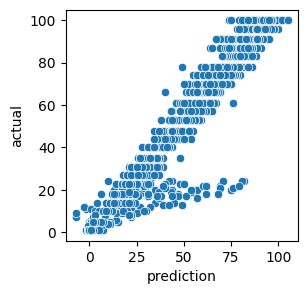

In [20]:
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.scatterplot(x=prediction, y=test_ds.y)
ax.set_xlabel('prediction')
ax.set_ylabel('actual')

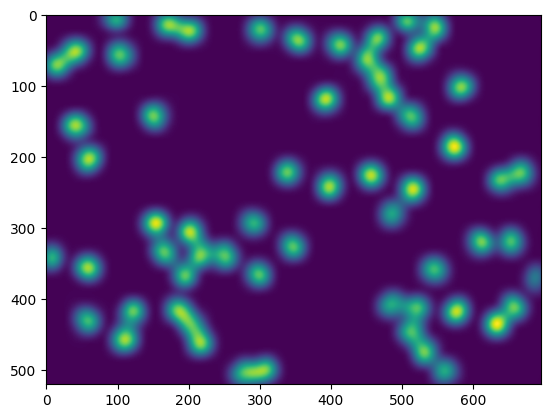

In [22]:
plt.imshow(test_ds.X[4])